<a href="https://colab.research.google.com/github/jiheddachraoui/occupancy_grid_generator/blob/main/SG_Scenario_Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREPARATION

In [48]:
import os
import sys
import csv
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import time
from collections import Counter
import tensorflow as tf
from sklearn.linear_model import RANSACRegressor
from scipy import stats
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [49]:
### Load carla data
datadir = '/content/drive/MyDrive/s_data/'
scenario='ground truth/scenario7_gt'

vehicles = []
folder_paths=[]
for item in os.listdir(os.path.join(datadir, scenario)):
    vehicles.append(item)

for i, vehicle in enumerate(vehicles, start=1):
    variable_name = f'folder_path{i}'
    folder_path = os.path.join(datadir, scenario, vehicle)
    globals()[variable_name] = folder_path
    folder_paths.append(folder_path)

In [50]:
LABEL_COLORS = np.array([
    (255, 255, 255), # None
    (80, 80, 80),    # Building
    (100, 40, 40),   # Fences
    (55, 90, 80),    # Other
    (220, 20, 60),   # Pedestrian
    (153, 153, 153), # Pole
    (157, 234, 50),  # RoadLines
    (128, 64, 128),  # Road
    (244, 35, 232),  # Sidewalk
    (107, 142, 35),  # Vegetation
    (0, 0, 142),     # Vehicle
    (102, 102, 156), # Wall
    (220, 220, 0),   # TrafficSign
    (70, 130, 180),  # Sky
    (81, 0, 81),     # Ground
    (150, 100, 100), # Bridge
    (230, 150, 140), # RailTrack
    (180, 165, 180), # GuardRail
    (250, 170, 30),  # TrafficLight
    (110, 190, 160), # Static
    (170, 120, 50),  # Dynamic
    (45, 60, 150),   # Water
    (145, 170, 100), # Terrain
]) / 255.0 # normalize each channel [0-1] since is what Open3D uses

REDUCED_LABEL_COLORS = np.array([
    (255, 255, 255), # None
    (128, 64, 128),  # Road RoadLines
    (80, 80, 80),    # Building,Wall, static ,Fences
    (250, 170, 30),    # Other ,GuardRail ,RailTrack ,15Bridge
    (110, 190, 160), # Pole ;TrafficLight; Static
    (107, 142, 35),  # Vegetation
    (0, 0, 142),     # Vehicle Dynamic pedestrians
    (244, 35, 232),  # Sidewalk Ground Terrain
    (70, 130, 180),   # Water

]) / 255.0 # normalize each channel [0-1] since is what Open3D uses
label_names = [
    'None', 'Building', 'Fences', 'Other', 'Pedestrian', 'Pole', 'RoadLines',
    'Road', 'Sidewalk', 'Vegetation', 'Vehicle', 'Wall', 'TrafficSign', 'Sky',
    'Ground', 'Bridge', 'RailTrack', 'GuardRail', 'TrafficLight', 'Static',
    'Dynamic', 'Water', 'Terrain'
]

reduced_label_names = [
    'None', 'Road', 'Building', 'Bridge, Rail, Other', 'Static', 'Vegetation', 'Dynamic',
    'Ground', 'Water'
]

## Get Data

In [51]:
date =15

In [52]:
def load_matrix(folder_path,timestamp):
  ts = str(timestamp)
  for file_name in os.listdir(folder_path):
          if os.path.splitext(file_name)[0] == ts:

              file_path = os.path.join(folder_path,file_name)
              print(file_path)
              break

  m=np.load(file_path)
  return m

In [53]:
### Retrieve the provided calibration data
#matrix transforms the points from lidar space to world space.
'''import random

seed_value = 13

# Set the seed for the random number generator
random.seed(seed_value)
# Randomly permute the order of folder_paths
random.shuffle(folder_paths)'''

for i, folder_path in enumerate(folder_paths, start=1):
    transformation_matrices_path = os.path.join(folder_path, "pos_matrices/lidar_2_world")
    transformation_matrices_path_variable = f'transformation_matrices_path{i}'
    globals()[transformation_matrices_path_variable] = transformation_matrices_path

    location_path = os.path.join(folder_path, "location")
    location_path_variable = f'location_path{i}'
    globals()[location_path_variable] = location_path

    img_path = os.path.join(folder_path, "bird_eye/rgb")
    img_path_variable = f'img_path{i}'
    globals()[img_path_variable] = img_path
    img_variable = f'img{i}'
    globals()[img_variable] = Image.open(os.path.join(img_path,str(date)+'.jpg'))

    ogm_path = os.path.join(folder_path, "grids/sem_grid_gt")
    ogm_path_variable = f'ogm_path{i}'
    globals()[ogm_path_variable] = ogm_path

    Ogm_variable = f'Ogm{i}'
    globals()[Ogm_variable] = load_matrix(ogm_path, date)

    transformation_matrix_variable = f'transform{i}'
    globals()[transformation_matrix_variable] = load_matrix(transformation_matrices_path, date)
    transform = globals()[transformation_matrix_variable]


    location_variable = f'loc{i}'
    globals()[location_variable] = transform[:3, 3:].flatten().tolist()

    rotation_path = os.path.join(folder_path, "pos_matrices/rotation_pyr")
    rotation_path_variable = f'rot_path{i}'
    globals()[rotation_path_variable] = rotation_path

    rotation_variable = f'rot{i}'
    globals()[rotation_variable] = load_matrix(rotation_path, date)



    R = np.array(transform[:3, :3])
    pitch = np.arcsin(R[2, 0])
    yaw = -np.arctan2(R[1, 0], R[0, 0])
    roll = -np.arctan2(R[2, 1], R[2, 2])
    pose_variable = f'pose{i}'
    globals()[pose_variable] = np.array([globals()[location_variable][0], globals()[location_variable][1], yaw])


# Print the results
for i in range(1, len(vehicles) + 1):
    transformation_matrices_path_variable = f'transformation_matrices_path{i}'
    location_path_variable = f'location_path{i}'
    ogm_path_variable = f'ogm_path{i}'
    transformation_matrix_variable = f'transform{i}'
    location_variable = f'loc{i}'
    rotation_path_variable = f'rot_path{i}'
    rotation_variable = f'rot{i}'

    print(f'vehicle {i} transformation matrices path: {globals()[transformation_matrices_path_variable]}')
    print(f'vehicle {i} location path: {globals()[location_path_variable]}')
    print(f'vehicle {i} ogm path: {globals()[ogm_path_variable]}')
    print(f'vehicle {i} transformation matrix: {globals()[transformation_matrix_variable]}')
    print(f'vehicle {i} location: {globals()[location_variable]}')
    print(f'vehicle {i} rotation path: {globals()[rotation_path_variable]}')
    print(f'vehicle {i} rotation: {globals()[rotation_variable]}')
    pose_variable = f'pose{i}'
    print(f'vehicle {i} pose: {globals()[pose_variable]}')
    print('_________________________________________')




/content/drive/MyDrive/s_data/ground truth/scenario7_gt/Vehicle_3 vehicle.nissan.patrol/grids/sem_grid_gt/15.npy
/content/drive/MyDrive/s_data/ground truth/scenario7_gt/Vehicle_3 vehicle.nissan.patrol/pos_matrices/lidar_2_world/15.npy
/content/drive/MyDrive/s_data/ground truth/scenario7_gt/Vehicle_3 vehicle.nissan.patrol/pos_matrices/rotation_pyr/15.npy
/content/drive/MyDrive/s_data/ground truth/scenario7_gt/Vehicle_1 vehicle.nissan.micra/grids/sem_grid_gt/15.npy
/content/drive/MyDrive/s_data/ground truth/scenario7_gt/Vehicle_1 vehicle.nissan.micra/pos_matrices/lidar_2_world/15.npy
/content/drive/MyDrive/s_data/ground truth/scenario7_gt/Vehicle_1 vehicle.nissan.micra/pos_matrices/rotation_pyr/15.npy
/content/drive/MyDrive/s_data/ground truth/scenario7_gt/Vehicle_2 vehicle.mini.cooper_s/grids/sem_grid_gt/15.npy
/content/drive/MyDrive/s_data/ground truth/scenario7_gt/Vehicle_2 vehicle.mini.cooper_s/pos_matrices/lidar_2_world/15.npy
/content/drive/MyDrive/s_data/ground truth/scenario7_gt/

In [54]:
ogm1=Ogm1[:,:,0]
ogm2=Ogm2[:,:,0]

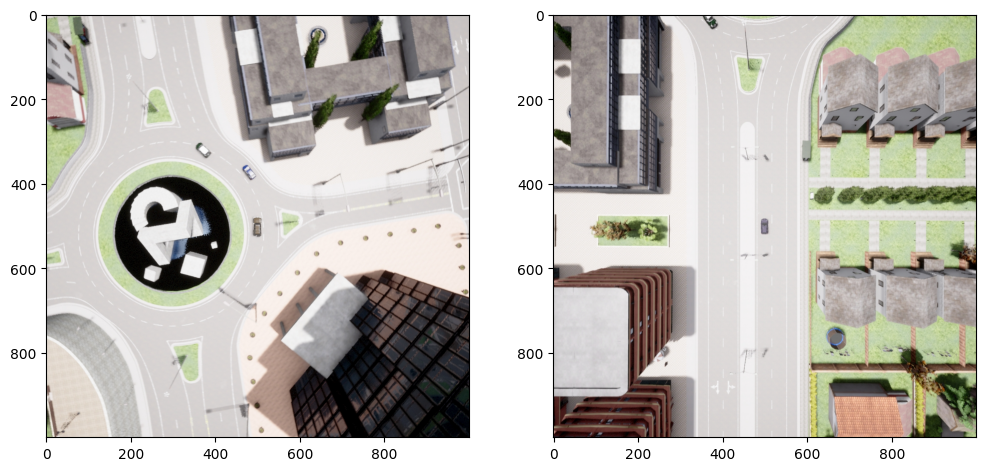

In [55]:
### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(img1)

axs[1].imshow(img2)

plt.show()

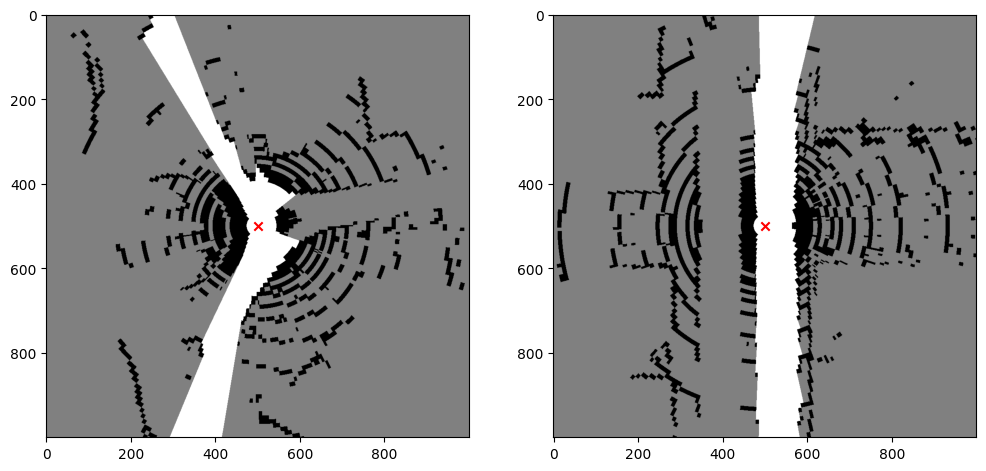

In [56]:
### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm1)*255).astype(np.uint8),cmap='gray')
axs[0].scatter(500,500,c='r',marker='x')
axs[1].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray')
axs[1].scatter(500,500,c='r',marker='x')
plt.show()

## Shift the map


compute pose from rotation matrix:
<br>
<center><img src="https://image1.slideserve.com/3199301/roll-pitch-yaw-l.jpg" width=400px></center>
</br>

(c=cos(), s=sin())

In [57]:
RESOLUTION = 0.1
# Calculate the relative position of the two vehicles
rel_pos = pose2[:2] - pose1[:2]
rel_orientation = pose2[2] - pose1[2]

# Define the translation and rotation matrices
#translation_matrix = np.array([[1, 0, -rel_pos[0]], [0, 1, -rel_pos[1]], [0, 0, 1]])
rotation_matrix = np.array([[np.cos(rel_orientation), -np.sin(rel_orientation), 0], [np.sin(rel_orientation), np.cos(rel_orientation), 0], [0, 0, 1]])
print(rotation_matrix)
print(-rel_pos[1]/RESOLUTION,-rel_pos[0]/RESOLUTION)
print(rel_orientation)


[[-0.98457654  0.17495437  0.        ]
 [-0.17495437 -0.98457654  0.        ]
 [ 0.          0.          1.        ]]
-684.359884262085 -221.83570861816406
3.3174520791070012


1.7402957738163312
[[22.18357086]
 [68.43598843]]
[ 334.10063189 -637.1313056     0.        ] -190.0760028697313


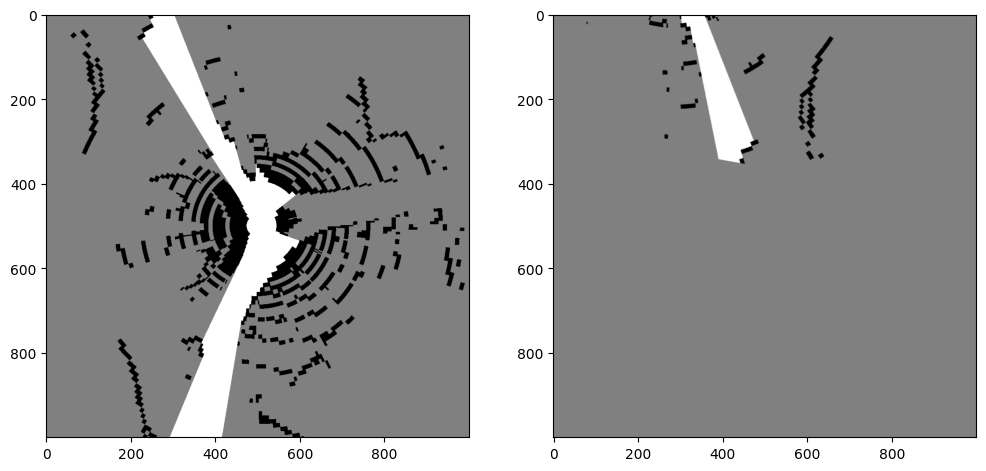

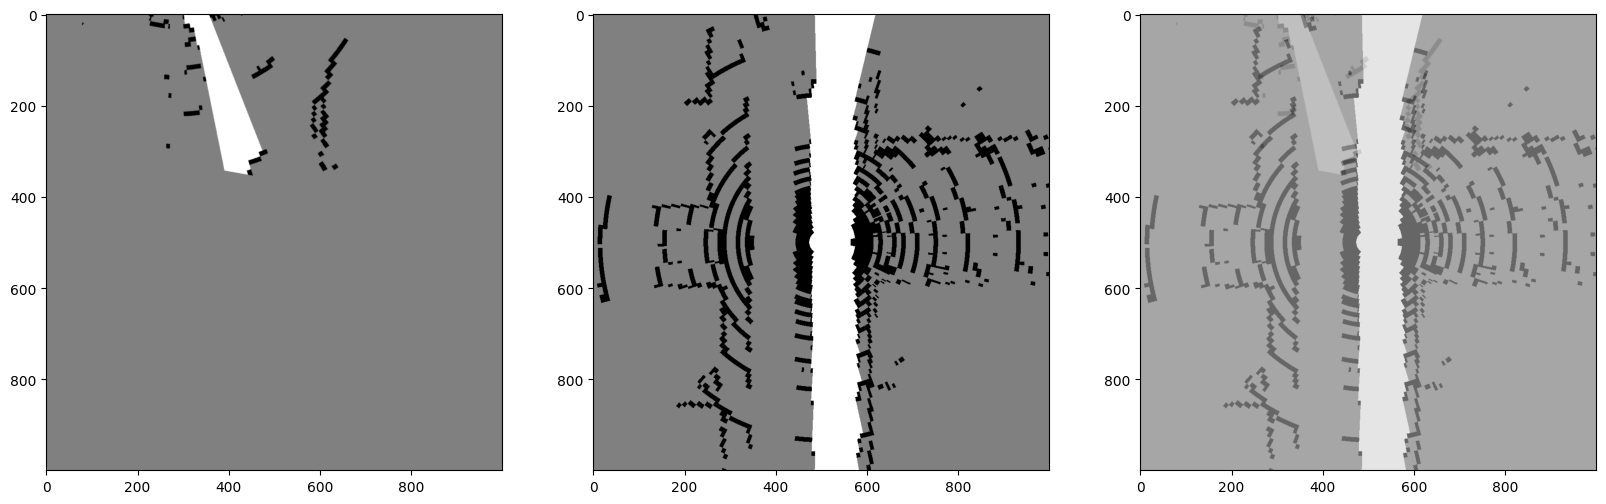

In [58]:
RESOLUTION = 0.1
# Shift the map according the vehicle's poses
def shift_pose_ogm(ogm, init, fin):
  ogm_o = ogm.copy()
  theta = -init[2]
  #theta = init[2]

  print(theta)
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  print(point_1)
  point_2 = np.dot(rot_m,-point_1)

  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])
  delta_theta = (fin[2] - init[2])

  print(delta,-delta_theta* 180 / np.pi)
  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(ogm_o,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)
  M = cv2.getRotationMatrix2D((ogm_o.shape[1]/2+0.5,ogm_o.shape[0]/2+0.5),-delta_theta* 180 / np.pi,1)
  #M = cv2.getRotationMatrix2D((ogm_o.shape[1]/2+0.5,ogm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)

  return dst

Ogm1_transformed = shift_pose_ogm(Ogm1,pose1,pose2)
ogm1_transformed=Ogm1_transformed[:,:,0]
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm1)*255).astype(np.uint8),cmap='gray')
axs[1].imshow(((1-ogm1_transformed)*255).astype(np.uint8),cmap='gray')

plt.show()

fig,axs = plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(((1-ogm1_transformed)*255).astype(np.uint8),cmap='gray')
axs[1].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray')
axs[2].imshow(((1-ogm1_transformed)*255).astype(np.uint8),cmap='gray', alpha=0.4)
axs[2].imshow(((1-ogm2)*255).astype(np.uint8), cmap='gray', alpha=0.5)
plt.show()

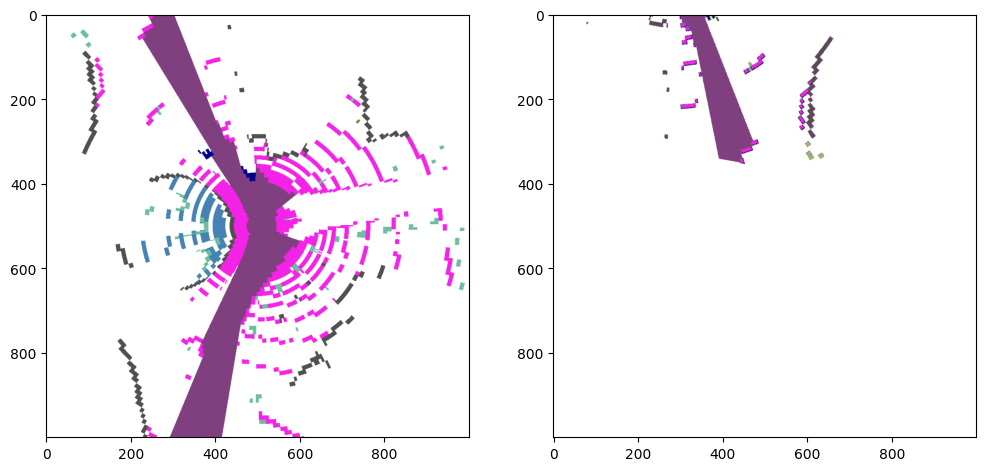

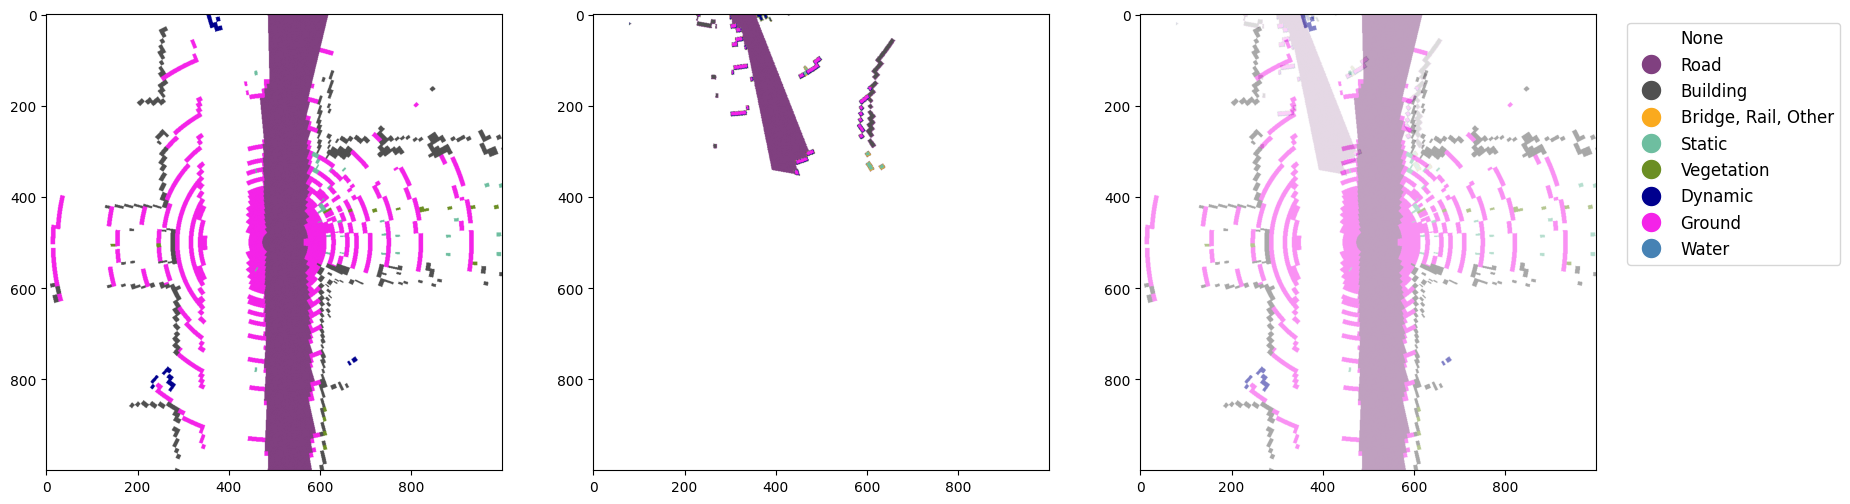

In [59]:


c1=REDUCED_LABEL_COLORS[Ogm1[:,:,1].astype(int)]
c1_transformed=REDUCED_LABEL_COLORS[Ogm1_transformed[:,:,1].astype(int)]
c2=REDUCED_LABEL_COLORS[Ogm2[:,:,1].astype(int)]

fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(c1)
axs[1].imshow(c1_transformed)

plt.show()

fig,axs = plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(c2)
axs[1].imshow(c1_transformed)
axs[2].imshow(c1_transformed, alpha=0.4)
axs[2].imshow(c2, alpha=0.5)
axs[2].axis('scaled')
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=reduced_label_names[i], markerfacecolor=REDUCED_LABEL_COLORS[i], markersize=15) for i in range(len(reduced_label_names))]
axs[2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')
plt.show()

# MAPPING (DGM)

In OGM, it is hard to tell which one among the detected obstacles are dynamic objects. Many imporvements have been done to make the OGM can store the information of dynamics object, which leads to a new type of grid map: Dynamic Grid Map (DGM). One simple approach that can be used to generate DGM is by using Dempster-Shafer Theory (DST), also known as evidential theory, to estimate the map instead of using probabilistic Bayesian theory.

In DST-based grid map, each cell's state is stored in form of a mass function $m$. This mass function consists of $m(\{F\}),m(\{O\}),m(\{F,O\}),m(\emptyset)$ that represent evidence that the cell is free, occupied, unknown, or conflicting respectively. The update algorithm for DST-based grid map is performed by using the Dempster's combination rule. In short, the conflicting evidence, which comes up when there are inconsistent measurements at the cell as time passed, may indicate that the cell is occupied by a dynamic object.


## load lidar data

In [60]:
def filter_road_points(lidar_in, is_road, threshold=0.5):
        y_true = lidar_in[:, 1]
        y = np.zeros_like(y_true)
        y = y_true * is_road  # set road points' predicted height to true height
        delta_y = np.absolute(y_true-y).flatten()
        is_not_road = delta_y > threshold
        lidar_out = lidar_in[is_not_road, :].copy()
        return lidar_out
for i, folder_path in enumerate(folder_paths, start=1):
    lidar_variable = f'lidar{i}'
    lidar_path = os.path.join(folder_path, "Lidar")
    lidar_file = os.path.join(lidar_path, f'{date}.npy')
    lidar_data = np.load(lidar_file)
    globals()[lidar_variable] = lidar_data.reshape(-1, 6)

    lidar_raw_variable = f'lidar_raw{i}'
    globals()[lidar_raw_variable] = globals()[lidar_variable].reshape(-1, 6)

    globals()[lidar_raw_variable] = globals()[lidar_raw_variable][globals()[lidar_raw_variable][:, 2] <= 0, :]

    radius = 2.7
    distances_variable = f'distances{i}'
    distances = np.sqrt((globals()[lidar_raw_variable][:, 0])**2 + (globals()[lidar_raw_variable][:, 1])**2)
    globals()[distances_variable] = distances

    globals()[lidar_raw_variable] = globals()[lidar_raw_variable][globals()[distances_variable] > radius, :]

    labels_variable = f'labels{i}'
    labels = np.array(globals()[lidar_raw_variable][:, 5]).astype(int)
    globals()[labels_variable] = labels

    lidar_labeled_variable = f'lidar_labeled{i}'
    lidar_labeled = np.array(globals()[lidar_raw_variable][..., [0, 1, 2, 5]])
    globals()[lidar_labeled_variable] = lidar_labeled

    globals()[lidar_raw_variable] = globals()[lidar_raw_variable][:, :3]

    road_filter_variable = f'road_filter{i}'
    road_filter = np.zeros_like(globals()[labels_variable])
    road_filter[(globals()[labels_variable] == 0) | (globals()[labels_variable] == 7) | (globals()[labels_variable] == 6)] = 1
    globals()[road_filter_variable] = road_filter

    lidar_nonroad_variable = f'lidar_nonroad{i}'
    globals()[lidar_nonroad_variable] = filter_road_points(globals()[lidar_raw_variable], globals()[road_filter_variable], 0.1)



## Parameters

The parameters mostly similar with OGM, but with addition:
- FREE_CONF = Our confidence level [0,1] in the results that are categorized as free.
- OCC_CONF = Our confidence level [0,1] in the results that are categorized as occupied.
- DYNAMIC_THRESHOLD = The minimal value of $m(\emptyset)$ to categorize a cell as occupied by dynamic object.



In [61]:
ALPHA = 1
BHETA = 1*np.pi/180
RESOLUTION = 0.1

MAX_RANGE = 70
MAP_WIDTH = 100
SPHERICAL2CARTESIAN_BIAS = 6
FREE_CONF = 0.7
OCC_CONF = 0.7
DYNAMIC_THRESHOLD = 0.4

## Map Initialization

The OGM is initialized with mass function of all of its cells, $m(\{F\})=0,m(\{O\})=0,m(\{F,O\})=1,m(\emptyset)=0$.

This means that we still don't have any information about the occupancy of the cells.

In [62]:
MAP_SIZE_X = int(MAP_WIDTH/RESOLUTION)
MAP_SIZE_Y = int(MAP_WIDTH/RESOLUTION)
xarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
yarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
MAP_XX, MAP_YY = np.meshgrid(xarr, -yarr)
rgrid = np.sqrt(np.add(np.square(MAP_XX),np.square(MAP_YY)))
OOR_MASK = rgrid >= MAX_RANGE

'''
DGM Channel:
Channel 0 = {F,O}
Channel 1 = O
Channel 2 = F
'''
dgm_time_0 = np.zeros((MAP_SIZE_Y,MAP_SIZE_X,3))
dgm_time_0[:,:,0] = 1

num_lidar = len(folder_paths)

for i in range(1, num_lidar + 1):
    lidar_nonroad_variable = f'lidar_nonroad{i}'
    lidar_dgm_variable = f'lidar_dgm{i}'

    globals()[lidar_dgm_variable] = globals()[lidar_nonroad_variable][:, [0, 1]]

## Generate Measurement Grid from Filtered LiDAR

The overall process of scan grid generation is the same as in OGM. The only difference is how we fill the cells according to condition 1, 2, and 3 (refer to the image in OGM measurement grid generation code). Cell under condition:

1. (Black cells/likely to be occupied) - are given mass function

\begin{align}m(\{F\})=0, m(\{O\})=OCC\_CONF, m(\{F,O\})=1-OCC\_CONF\end{align}

2. (White cells/likely to be free) - are given mass function

\begin{align}m(\{F\})=FREE\_CONF, m(\{O\})=0, m(\{F,O\})=1-FREE\_CONF\end{align}

3. (Gray cells/unknown) - are given mass function

\begin{align}m(\{F\})=0, m(\{O\})=0, m(\{F,O\})=1\end{align}

The value of $m(\emptyset)$ is 0 and should always be 0, according to DST. We only use $m(\emptyset)$ to detect dynamic cells at an instant time.


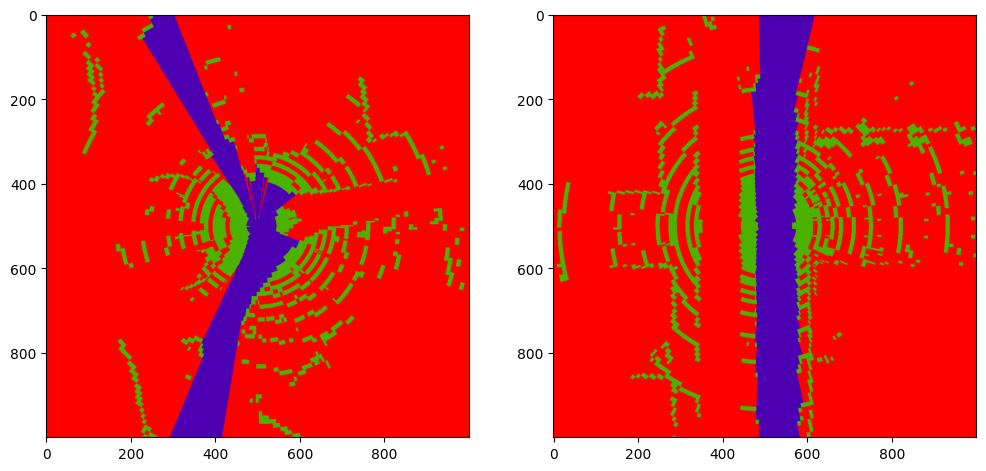

In [63]:
def generate_measurement_dgm(lidar_in,dgm_shape):
  ### Calculate the position of LiDAR points in spherical coordinate
  rphi_meas = np.zeros((lidar_in.shape[0],2))
  rphi_meas[:,1] = np.sqrt(np.add(np.square(lidar_in[:,0]),np.square(lidar_in[:,1])))/ALPHA
  rphi_meas[:,0] = (np.arctan2(lidar_in[:,1],lidar_in[:,0])+np.pi)/BHETA
  rphi_meas = np.unique(rphi_meas.astype(int),axis=0)
  rphi_meas = rphi_meas[rphi_meas[:,1]<int(MAX_RANGE/ALPHA),:]
  rphi_meas = rphi_meas[rphi_meas[:,0]<int(2*np.pi/BHETA),:]

  ### Initiate and fill the spherical scan grid
  sg_ang_bin = int(2*np.pi/BHETA)
  sg_rng_bin = int(MAX_RANGE/ALPHA)
  scan_grid = np.zeros((sg_ang_bin,sg_rng_bin,3))
  scan_grid[:,:,0] = 1
  scan_grid[tuple(rphi_meas.T)] = (1-OCC_CONF,OCC_CONF,0)
  for ang in range(sg_ang_bin):
    ang_arr = rphi_meas[rphi_meas[:,0]==ang,1]
    if len(ang_arr) == 0:
      scan_grid[ang,:] = (1-FREE_CONF,0,FREE_CONF)
    else:
      min_r = np.min(ang_arr)
      scan_grid[ang,:min_r] = (1-FREE_CONF,0,FREE_CONF)

  ### Convert the spherical scan grid to the cartesian one
  dgm_sz = (dgm_shape[1],dgm_shape[0])
  dgm_cen = (int(dgm_shape[1]/2),int(dgm_shape[0]/2))
  radius = (MAX_RANGE/RESOLUTION) + SPHERICAL2CARTESIAN_BIAS
  dgm_step = cv2.warpPolar(scan_grid,dgm_sz,dgm_cen,radius,cv2.WARP_INVERSE_MAP)
  dgm_step[OOR_MASK] = (1,0,0)
  dgm_step = cv2.rotate(dgm_step, cv2.ROTATE_90_CLOCKWISE)
  return dgm_step

for i in range(1, num_lidar + 1):
    lidar_dgm_variable = f'lidar_dgm{i}'
    dgm_variable = f'dgm{i}'

    globals()[dgm_variable] = generate_measurement_dgm(globals()[lidar_dgm_variable], dgm_time_0.shape)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow((dgm1*255).astype(np.uint8))
axs[1].imshow((dgm2*255).astype(np.uint8))
plt.show()

In [64]:
print(dgm1[500,500])

[0.3 0.  0.7]


## Try First Update

The update of DGM is done with Dempster's rule of combination. By theory, to combine two mass functions $m_1$ and $m_2$ into a new mass function $m_{1,2}$, the following formula is used

\begin{align}
m_{1,2}(A)=\frac{1}{1-K}\sum_{B\cap C=A\neq\emptyset} m_1(B).m_2(C)
\end{align}

\begin{align}
m(\emptyset) = 0
\end{align}

\begin{align}
K=\sum_{B\cap C=\emptyset} m_1(B).m_2(C)
\end{align}

Note that te sum of all evindeces in a mass function must be equal to 1. If we apply it to the DGM case, the combination rule will be

\begin{align}
m_{1,2}(\{F\})=\frac{1}{1-K}(m_1(\{F\}).m_2(\{F,O\}) + m_1(\{F,O\}).m_2(\{F\}))
\end{align}

\begin{align}
m_{1,2}(\{O\})=\frac{1}{1-K}(m_1(\{O\}).m_2(\{F,O\}) + m_1(\{F,O\}).m_2(\{O\}))
\end{align}

\begin{align}
m_{1,2}(\{F,O\})=\frac{1}{1-K}(m_1(\{F,O\}).m_2(\{F,O\}))
\end{align}

\begin{align}
m_{1,2}(\emptyset) = 0
\end{align}

\begin{align}
K=m_1(\{O\}).m_2(\{F\}) + m_1(\{F\}).m_2(\{O\}))
\end{align}


To categorize the cells, we only need to find the maximum mass in its mass function. For example, if the maximum mass is $F$, it will be categorized as free cell. But, cells that have $K>DYNAMIC\_THRESHOLD$ will be classified as dynamic cells.


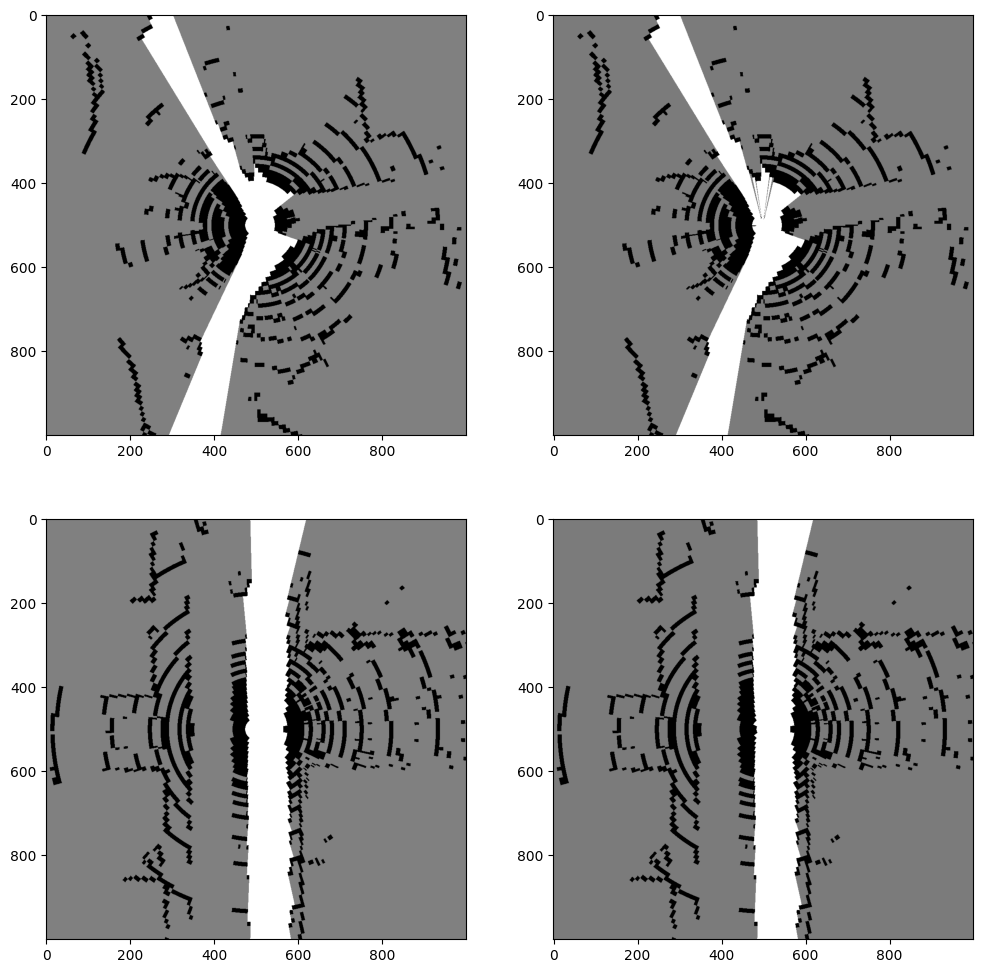

In [65]:
### Update the DGM with DST rule of combination
def update_dgm(prior_dgm,new_dgm):
  ### Calculate conflicting mass
  conflict_mass = np.multiply(prior_dgm[:,:,2],new_dgm[:,:,1])
  conflict_mass = np.add(conflict_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,2]))

  ### Calculate free mass
  free_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,2])
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,0]))
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,2]))
  free_mass = np.divide(free_mass,1-conflict_mass)

  ### Calculate occupied mass
  occ_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,1])
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,0]))
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,1]))
  occ_mass = np.divide(occ_mass,1-conflict_mass)

  ### Calculate unknown mass
  unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])
  unknown_mass = np.divide(unknown_mass,1-conflict_mass)

  updated_dgm = np.stack((unknown_mass,occ_mass,free_mass),axis=2)
  return updated_dgm,conflict_mass

### Convert the DGM to a displayable figure
def predict_dgm(dgm,dynamic_mass,dt=DYNAMIC_THRESHOLD):
  max_mass = np.argmax(dgm,axis=2)
  pred_map = np.zeros(dgm.shape)
  # The unknown cells: gray
  pred_map[max_mass==0] = (123,123,123)
  # The occupied cells: black
  pred_map[max_mass==1] = (0,0,0)
  # The free cells: white
  pred_map[max_mass==2] = (255,255,255)
  # The dynamic cells: blue
  pred_map[dynamic_mass>=dt] = (0,0,200)
  return pred_map.astype(np.uint8)

for i in range(1, num_lidar + 1):
    dgm_variable = f'dgm{i}'
    dgm_time_variable = f'dgm_time_{i}'
    dynamic_mass_variable = f'dynamic_mass_{i}'
    dgm_pred_variable = f'dgm_pred_{i}'

    globals()[dgm_time_variable], globals()[dynamic_mass_variable] = update_dgm(dgm_time_0, globals()[dgm_variable])
    globals()[dgm_pred_variable] = predict_dgm(globals()[dgm_time_variable], globals()[dynamic_mass_variable])


fig,axs = plt.subplots(2,2,figsize=(12,12))
axs[0,0].imshow(((1-ogm1)*255).astype(np.uint8),cmap='gray')
axs[0,1].imshow(dgm_pred_1)
axs[1,0].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray')
axs[1,1].imshow(dgm_pred_2)

plt.show()

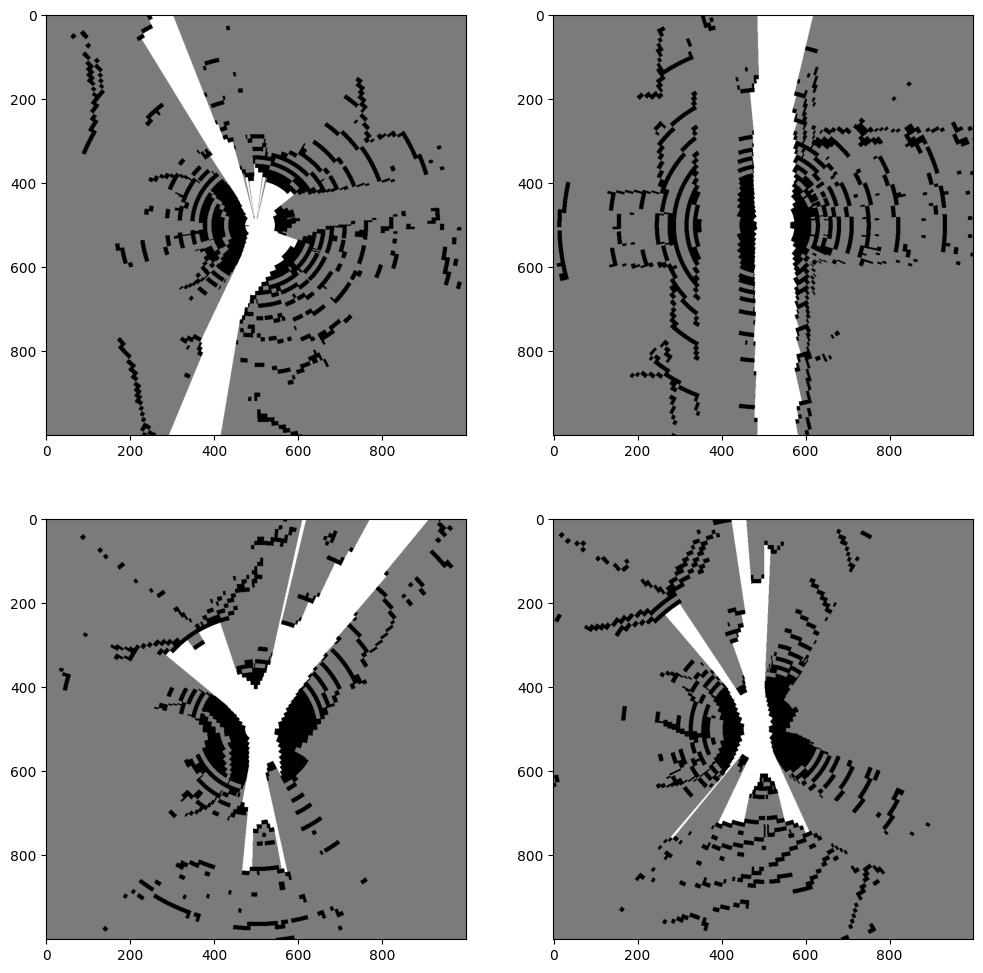

In [66]:
if 'pose4' in globals():
  fig,axs = plt.subplots(2,2,figsize=(12,12))
  axs[0,0].imshow(dgm_pred_1)
  axs[0,1].imshow(dgm_pred_2)
  axs[1,0].imshow(dgm_pred_3)
  axs[1,1].imshow(dgm_pred_4)

  plt.show()

## Shift the DGM

Shift the OGM with the same way as with OGM

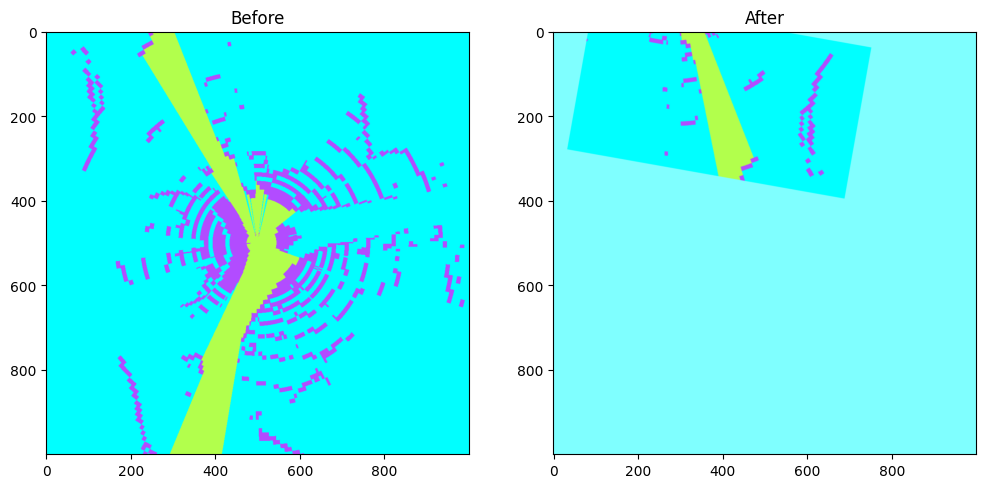

In [67]:
#RESOLUTION=RESOLUTION -25
# Shift the map according the vehicle's poses
def shift_pose_dgm(dgm, init, fin):
  dgm_o = dgm.copy()
  #theta = init[2] /180 * np.pi
  theta = -init[2]
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  point_2 = np.dot(rot_m,-point_1)
  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])

  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(dgm_o,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=0.5)
  M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),-delta_theta* 180 / np.pi,1)
  #M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=0.5)
  return dst

shift_dgm_time_1 = shift_pose_dgm(dgm_time_1,pose1,pose2)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-dgm_time_1)*255).astype(np.uint8),cmap='gray')
axs[0].set_title('Before')
axs[1].imshow(((1-shift_dgm_time_1)*255).astype(np.uint8),cmap='gray')
axs[1].set_title('After')
plt.show()

## The Second Update

Let's update the map again!

The dynamic cells are colored blue.

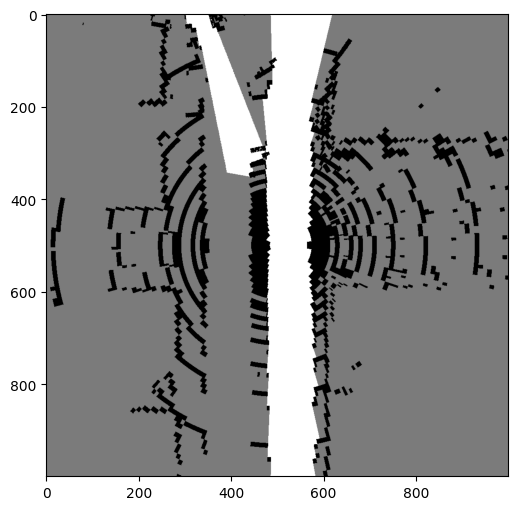

In [68]:
dgm_fuse,dynamic_mass_fuse = update_dgm(shift_dgm_time_1,dgm_time_2)
dgm_pred_fuse = predict_dgm(dgm_fuse,dynamic_mass_fuse,0.5)

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(dgm_pred_fuse)
plt.show()

## The third update (if exists)

In [69]:
if 'pose3' in globals():
    shift_dgm_time_3 = shift_pose_dgm(dgm_time_3, pose3, pose2)


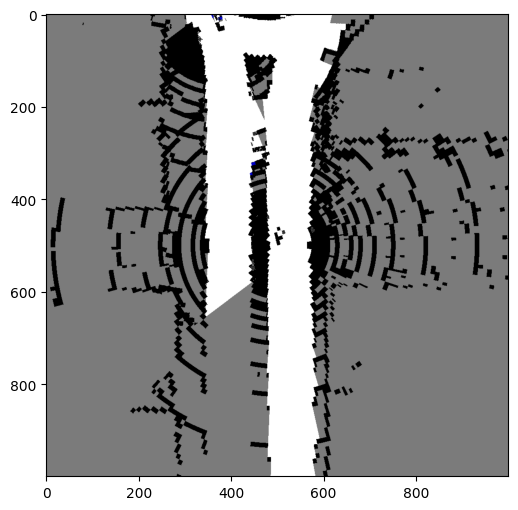

In [70]:
if 'pose3' in globals():
  dgm_fuse,dynamic_mass_fuse = update_dgm(dgm_fuse,shift_dgm_time_3)
  dgm_pred_fuse = predict_dgm(dgm_fuse,dynamic_mass_fuse,0.5)

  fig,axs = plt.subplots(1,1,figsize=(6,6))
  axs.imshow(dgm_pred_fuse)
  plt.show()

## The fourth update (if exists)

In [71]:
if 'pose4' in globals():
  shift_dgm_time_4 = shift_pose_dgm(dgm_time_4, pose4, pose2)


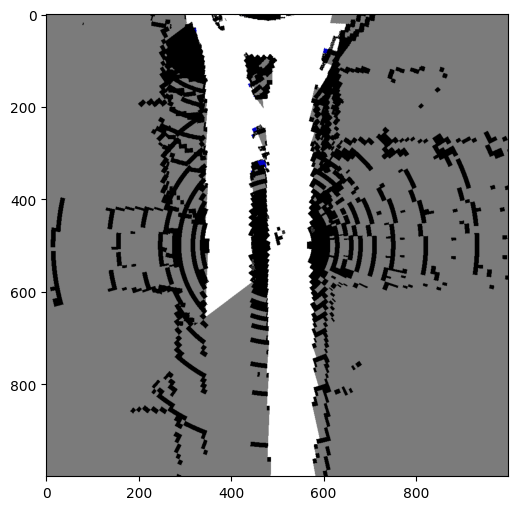

In [72]:
if 'pose4' in globals():
  dgm_fuse,dynamic_mass_fuse = update_dgm(dgm_fuse,shift_dgm_time_4 )
  dgm_pred_fuse = predict_dgm(dgm_fuse,dynamic_mass_fuse,0.5)

  fig,axs = plt.subplots(1,1,figsize=(6,6))
  axs.imshow(dgm_pred_fuse)
  plt.show()

# MAPPING (SGM)


## load lidar data

In [73]:
for i in range(1, num_lidar+1):
    labels_variable = f'labels{i}'
    reduced_labels_variable = f'reduced_labels{i}'
    reduced_color_variable = f'reduced_color{i}'
    lidar_rlabeled_variable = f'lidar_rlabeled{i}'
    lidar_nonroad_rlabeled_variable = f'lidar_nonroad_rlabeled{i}'

    globals()[reduced_labels_variable] = np.zeros_like(globals()[labels_variable])
    globals()[reduced_labels_variable][(globals()[labels_variable] == 7) | (globals()[labels_variable] == 6)] = 1
    globals()[reduced_labels_variable][(globals()[labels_variable] == 1) | (globals()[labels_variable] == 2) | (globals()[labels_variable] == 11) | (globals()[labels_variable] == 19)] = 2
    globals()[reduced_labels_variable][(globals()[labels_variable] == 3) | (globals()[labels_variable] == 15) | (globals()[labels_variable] == 17) | (globals()[labels_variable] == 18)] = 3
    globals()[reduced_labels_variable][(globals()[labels_variable] == 5) | (globals()[labels_variable] == 18) | (globals()[labels_variable] == 19)] = 4
    globals()[reduced_labels_variable][(globals()[labels_variable] == 9)] = 5
    globals()[reduced_labels_variable][(globals()[labels_variable] == 4) | (globals()[labels_variable] == 10) | (globals()[labels_variable] == 20)] = 6
    globals()[reduced_labels_variable][(globals()[labels_variable] == 8) | (globals()[labels_variable] == 14) | (globals()[labels_variable] == 22)] = 7
    globals()[reduced_labels_variable][(globals()[labels_variable] == 21)] = 8

    globals()[reduced_color_variable] = REDUCED_LABEL_COLORS[globals()[reduced_labels_variable]]

    lidar_raw_variable = f'lidar_raw{i}'
    globals()[lidar_rlabeled_variable] = np.concatenate((globals()[lidar_raw_variable], globals()[reduced_labels_variable][..., np.newaxis]), axis=-1)

    road_filter_variable = f'road_filter{i}'
    globals()[lidar_nonroad_rlabeled_variable] = filter_road_points(globals()[lidar_rlabeled_variable], globals()[road_filter_variable], 0.1)

    # Assign variables to dynamic variables
    exec(f"reduced_labels{i} = globals()[reduced_labels_variable]")
    exec(f"reduced_color{i} = globals()[reduced_color_variable]")
    exec(f"lidar_rlabeled{i} = globals()[lidar_rlabeled_variable]")
    exec(f"lidar_nonroad_rlabeled{i} = globals()[lidar_nonroad_rlabeled_variable]")


## Parameters

In [74]:
ALPHA = 1
BHETA = 1*np.pi/180
RESOLUTION = 0.1

MAX_RANGE = 100
MAP_WIDTH = 100
SPHERICAL2CARTESIAN_BIAS = 6


DYNAMIC_THRESHOLD = 0.4

## Map Initialization

$m(\{C_1\}),...,m(\{C_i\}),m(\{C_1,..,C_i\}),m(\emptyset)$.

In [75]:
MAP_SIZE_X = int(MAP_WIDTH/RESOLUTION)
MAP_SIZE_Y = int(MAP_WIDTH/RESOLUTION)
xarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
yarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
MAP_XX, MAP_YY = np.meshgrid(xarr, -yarr)
rgrid = np.sqrt(np.add(np.square(MAP_XX),np.square(MAP_YY)))
OOR_MASK = rgrid >= MAX_RANGE

'''
DGM Channel:
Channel 0 = {F,O}
Channel 1 = O
Channel 2 = F
'''
num_classes=REDUCED_LABEL_COLORS.shape[0]
#print(num_classes)
sgm_time_0 = np.zeros((MAP_SIZE_Y,MAP_SIZE_X,num_classes))
sgm_time_0[:,:,0] = 1

for i in range(1, num_lidar + 1):
    lidar_nonroad_rlabeled_variable = f'lidar_nonroad_rlabeled{i}'
    lidar_sgm_variable = f'lidar_sgm{i}'

    lidar_nonroad_rlabeled = globals()[lidar_nonroad_rlabeled_variable]
    globals()[lidar_sgm_variable] = lidar_nonroad_rlabeled[:, [0, 1, 3]]

    # Assign variables to dynamic variables
    exec(f"lidar_sgm{i} = globals()[lidar_sgm_variable]")


In [76]:
sgm_time_0.shape

(1000, 1000, 9)

## Generate Measurement Grid from Filtered LiDAR


For cells labeled with a specific object class\\

m['Class1'] = C1_CONF \\
m['Class2'] = C2_CONF \\
m['Class3'] = C3_CONF \\
m['Class4'] = C4_CONF \\
m['Class5'] = C5_CONF \\
m['Class6'] = C6_CONF \\
m['Class7'] = C7_CONF \\
m['Class8'] = C8_CONF \\
m['Class0'] = 1 - (C1_CONF + C2_CONF + C3_CONF + C4_CONF + C5_CONF + C6_CONF + C7_CONF + C8_CONF) \\

For cells not labeled with any of the specific object classes \\

m['Class1'] = 0 \\
m['Class2'] = 0 \\
m['Class3'] = 0 \\
m['Class4'] = 0 \\
m['Class5'] = 0 \\
m['Class6'] = 0 \\
m['Class7'] = 0 \\
m['Class8'] = 0 \\
m['Class0'] = 1 \\

In [77]:
REDUCED_LABEL_COLORS = np.array([
    (255, 255, 255), # None
    (128, 64, 128),  # Road RoadLines
    (80, 80, 80),    # Building,Wall, static ,Fences
    (250, 170, 30),    # Other ,GuardRail ,RailTrack ,15Bridge
    (110, 190, 160), # Pole ;TrafficLight; Static
    (107, 142, 35),  # Vegetation
    (0, 0, 142),     # Vehicle Dynamic pedestrians
    (244, 35, 232),  # Sidewalk Ground Terrain
    (70, 130, 180),   # Water

]) / 255.0 # normalize each channel [0-1] since is what Open3D uses

[0 1 2 4 5 6 7 8]


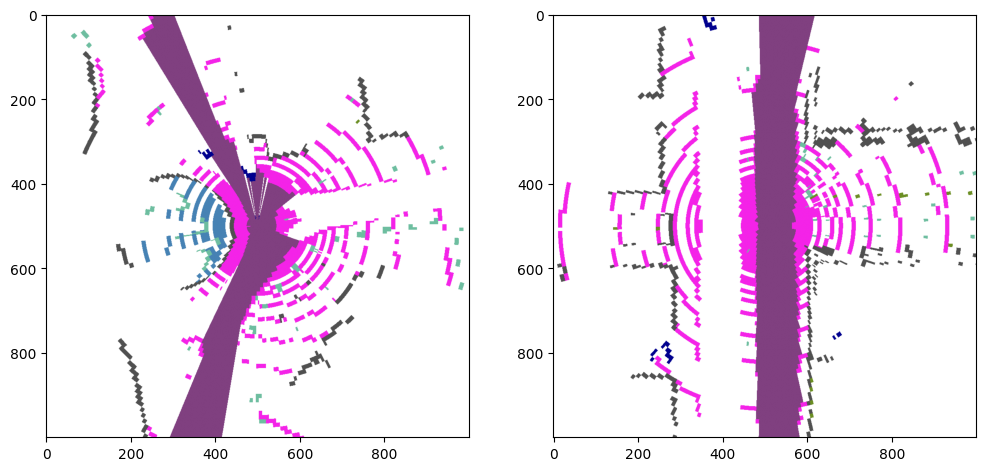

In [78]:
L0_w = 0.1
L1_w = 0.8
L2_w = 1
L3_w = 1
L4_w = 1
L5_w = 1
L6_w = 1
L7_w = 1
L8_w = 1



label_weights={
    0 : L0_w,
    1 : L1_w,
    2 : L2_w,
    3 : L3_w,
    4 : L4_w,
    5 : L5_w,
    6 : L6_w,
    7 : L7_w,
    8 : L8_w}



def generate_semantic_dgm(lidar_in, ogm_shape):
  ### Calculate the position of LiDAR points in spherical coordinate
    rphi_meas = np.zeros((lidar_in.shape[0], 3))
    rphi_meas[:, 1] = np.sqrt(np.add(np.square(lidar_in[:, 0]), np.square(lidar_in[:, 1]))) / ALPHA
    rphi_meas[:, 0] = (np.arctan2(lidar_in[:, 1], lidar_in[:, 0]) + np.pi) / BHETA
    rphi_meas[:, 2]=lidar_in[:,2]


    rphi_meas = np.unique(rphi_meas.astype(int), axis=0)

    rphi_meas = rphi_meas[rphi_meas[:, 1] < int(MAX_RANGE / ALPHA), :]
    rphi_meas = rphi_meas[rphi_meas[:, 0] < int(2 * np.pi / BHETA), :]

    ### Initiate and fill the spherical scan grid
    sg_ang_bin = int(2 * np.pi / BHETA)
    sg_rng_bin = int(MAX_RANGE / ALPHA)
    # Initiation (Condition 3)

    label_grid_np = np.zeros((sg_ang_bin, sg_rng_bin,num_classes))
    label_grid_np[:,:,0] = 1
    label_grid = [[[] for _ in range(sg_rng_bin)] for _ in range(sg_ang_bin)]

    # Condition 1

    for i in range(rphi_meas.shape[0]):

      ang = rphi_meas[i, 0]
      rng = rphi_meas[i, 1]
      label = rphi_meas[i, 2]
      #label_grid[int(ang), int(rng)] = label
      label_grid[ang][rng].append(label)

    # Assign majority label to each cell
    for ang in range(sg_ang_bin):
        for rng in range(sg_rng_bin):
            cell_labels = label_grid[ang][rng]

            # Exclude label 0 from the list of cell_labels
            #cell_labels = [label for label in cell_labels if label != 0]


            if len(cell_labels) > 0:
                # Count the occurrences of each label
                  label_counts = Counter(cell_labels)
                  label_counts = {label: label_counts[label] * label_weights.get(label, 1) for label in label_counts}
                  total_count = sum(label_counts.values())

                  # Calculate the appearance percentage for each label in cell_labels
                  appearance_percentages = {label: count / total_count for label, count in label_counts.items()}

                  # Fill in the remaining labels in label_counts with 0 counts
                  for label in range(num_classes):
                      if label not in label_counts:
                          label_counts[label] = 0

                  appearance_tuple = tuple(appearance_percentages.get(label, 0) for label in range(num_classes))
                  #print(appearance_tuple)
                  # Assign the appearance tuple to the grid cell
                  label_grid_np[ang][rng] = appearance_tuple
            else:

              label_grid_np[ang][rng] = (1,0,0,0,0,0,0,0,0)
    center = sg_ang_bin // 2
    for ang in range(sg_ang_bin):
        ang_arr = rphi_meas[rphi_meas[:, 0] == ang, 1]

        if len(ang_arr) == 0:

            label_grid_np[ang, :] = (0.3,0.7,0,0,0,0,0,0,0)
        else:

            min_r = np.min(ang_arr)

            label_grid_np[ang, :(min_r)] = (0.3,0.7,0,0,0,0,0,0,0)

            #label_grid_np[ang, :3] = (0.2, 0.6, 0, 0, 0, 0 ,0.2, 0, 0)


    ### Convert the spherical scan grid to the cartesian one
    ogm_sz = (ogm_shape[1], ogm_shape[0])
    ogm_cen = (int(ogm_shape[1] / 2), int(ogm_shape[0] / 2))
    radius = (MAX_RANGE / RESOLUTION) + SPHERICAL2CARTESIAN_BIAS

    label_step = cv2.warpPolar(label_grid_np, ogm_sz, ogm_cen, radius, cv2.WARP_INVERSE_MAP)

    label_step[OOR_MASK] = (1,0,0,0,0,0,0,0,0)
    for i in range(label_step.shape[-1]):
        label_step[:, :, i] = cv2.rotate(label_step[:, :, i], cv2.ROTATE_90_CLOCKWISE)
    #label_step = cv2.rotate(label_step, cv2.ROTATE_90_CLOCKWISE)


    return label_step




sdgm_step = generate_semantic_dgm(lidar_rlabeled1[:,[0,1,3]],sgm_time_0.shape)
c=REDUCED_LABEL_COLORS[sdgm_step.astype(int)]

for i in range(1, num_lidar + 1):
    lidar_sgm_variable = f'lidar_sgm{i}'
    sgm_variable = f'sgm{i}'

    globals()[sgm_variable] = generate_semantic_dgm(globals()[lidar_sgm_variable], sgm_time_0.shape)


### Visualize

fig,axs = plt.subplots(1,2,figsize=(12,6))
print(np.unique(np.argmax(sgm1,axis=2)))
axs[0].imshow(REDUCED_LABEL_COLORS[np.argmax(sgm1,axis=2).astype(int)])
axs[1].imshow(REDUCED_LABEL_COLORS[np.argmax(sgm2,axis=2).astype(int)])
plt.show()

In [79]:

print(sgm1[100,500])
print(np.unique(sgm1))
print(sgm1.shape)


[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.3 0.5 0.7 1. ]
(1000, 1000, 9)


## Try First Update

The update of DGM is done with Dempster's rule of combination. By theory, to combine two mass functions $m_1$ and $m_2$ into a new mass function $m_{1,2}$, the following formula is used

\begin{align}
m_{1,2}(A)=\frac{1}{1-K}\sum_{B\cap C=A\neq\emptyset} m_1(B).m_2(C)
\end{align}

\begin{align}
m(\emptyset) = 0
\end{align}

\begin{align}
K=\sum_{B\cap C=\emptyset} m_1(B).m_2(C)
\end{align}


for combinig the functions using Dempster's rule modified by Yager, the following formula is used

\begin{align}
m_{1,2}(A)=\sum_{B\cap C=A\neq\emptyset} m_1(B).m_2(C)\  +K
\end{align}

\begin{align}
m(\emptyset) = 0
\end{align}

\begin{align}
K=\sum_{B\cap C=\emptyset} m_1(B).m_2(C)
\end{align}




Note that te sum of all evindeces in a mass function must be equal to 1.

[0 1 2 4 5 6 7 8]
[0 1 2 4 5 6 7]
[0 1 2 4 5 6 7 8]
[0 1 2 4 6 7 8]
[0.         0.1372549  0.25098039 0.2745098  0.31372549 0.41960784
 0.43137255 0.50196078 0.50980392 0.55686275 0.62745098 0.70588235
 0.74509804 0.90980392 0.95686275 1.        ]


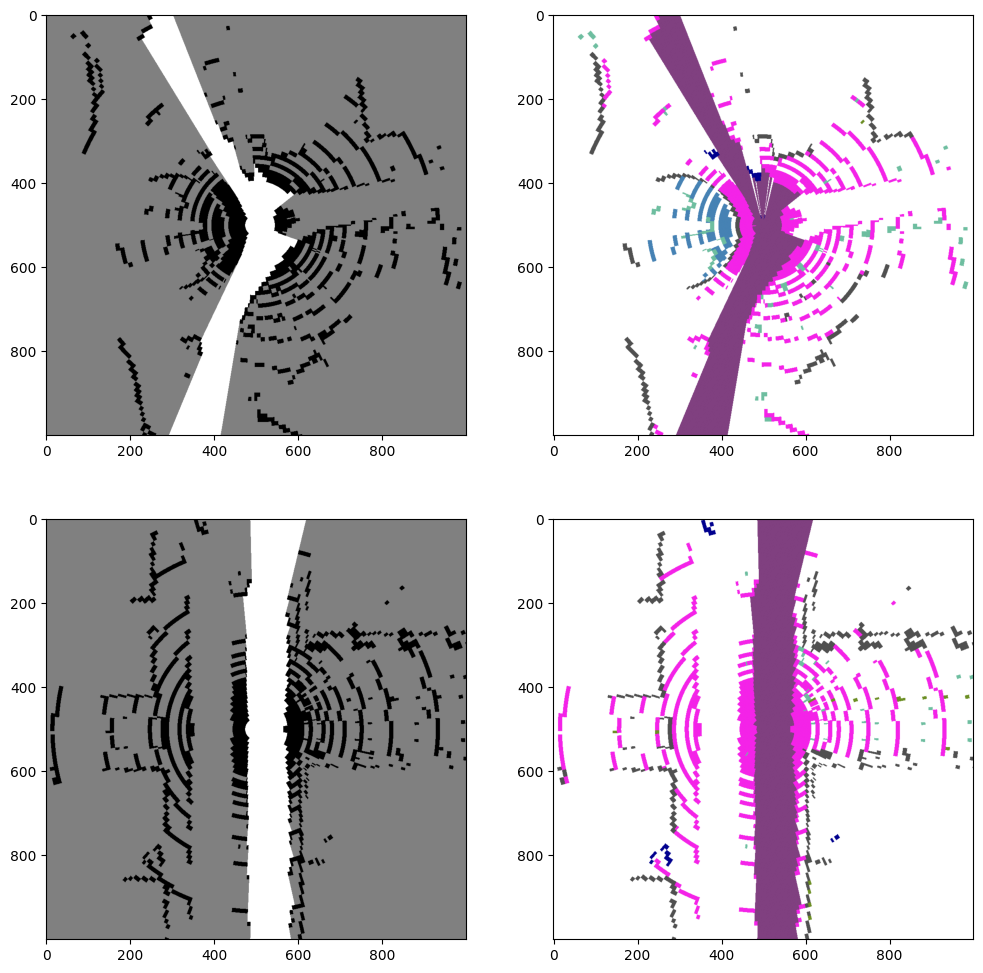

In [80]:
import numpy as np

# Update the SGM with DST rule of combination
def update_sgm(prior_dgm, new_dgm):
    num_classes = new_dgm.shape[2]

    conflict_mass = np.zeros_like(new_dgm[:, :, 0])
    class_mass = np.zeros_like(new_dgm[:, :, 1:])



    for i in range(1,num_classes):
        for j in range(1,num_classes):

            if i != j:
                conflict_mass += np.multiply(prior_dgm[:, :, i], new_dgm[:, :, j])
                conflict_mass += np.multiply(prior_dgm[:, :, j], new_dgm[:, :, i])

        class_mass[:, :, i-1] += np.multiply(prior_dgm[:, :, 0], new_dgm[:, :, i])
        class_mass[:, :, i-1] += np.multiply(prior_dgm[:, :, i], new_dgm[:, :, 0])
        #class_mass[:, :, i-1] = np.divide(class_mass[:, :, i-1], np.ones_like(conflict_mass) - conflict_mass +1e-10)  #DS
        class_mass[:, :, i-1] += conflict_mass #yager
        #class_mass[:, :, i-1] += np.divide(class_mass[:, :, i-1], np.ones_like(conflict_mass) - conflict_mass +1e-10) #perso


    #class0 is the unknown mass
    unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])
    #unknown_mass = np.divide(unknown_mass,np.ones_like(conflict_mass) - conflict_mass+1e-10) #DS
    unknown_mass += conflict_mass #yager
    #unknown_mass = +np.divide(unknown_mass,np.ones_like(conflict_mass) - conflict_mass+1e-10) #perso
    updated_dgm = np.dstack((unknown_mass,class_mass))

    for i in range(prior_dgm.shape[0]):
      for j in range(prior_dgm.shape[1]):
          if np.array_equal(prior_dgm[i, j], new_dgm[i, j]):
              # If the belief values at (i, j) are the same element-wise, assign the values to the masses
              updated_dgm[i, j] = new_dgm[i, j]
              continue


    return updated_dgm, conflict_mass

# Convert the SGM to a displayable figure
def predict_sgm(dgm, dynamic_mass,DYNAMIC_THRESHOLD=0.4):

    max_mass = np.argmax(dgm, axis=2)

    pred_map = np.zeros(dgm[:,:,:3].shape)

    print(np.unique(max_mass))
    for i in range(num_classes):
        pred_map[max_mass == i] = REDUCED_LABEL_COLORS[i]

    # The dynamic cells: red
    pred_map[dynamic_mass >= DYNAMIC_THRESHOLD] = (200,0,0)#REDUCED_LABEL_COLORS[6]

    return pred_map



for i in range(1, num_lidar + 1):
    sgm_variable = f'sgm{i}'
    sgm_time_variable = f'sgm_time_{i}'
    dynamic_mass_variable = f'dynamic_mass_{i}'
    sgm_pred_variable = f'sgm_pred_{i}'

    globals()[sgm_time_variable], globals()[dynamic_mass_variable] = update_sgm(sgm_time_0, globals()[sgm_variable])
    globals()[sgm_pred_variable] = predict_sgm(globals()[sgm_time_variable], globals()[dynamic_mass_variable],0.7)


print(np.unique(sgm_pred_1))


fig,axs = plt.subplots(2,2,figsize=(12,12))
axs[0,0].imshow(((1-ogm1)*255).astype(np.uint8),cmap='gray')
axs[0,1].imshow(sgm_pred_1)
axs[1,0].imshow(((1-ogm2)*255).astype(np.uint8),cmap='gray')
axs[1,1].imshow(sgm_pred_2)

plt.show()

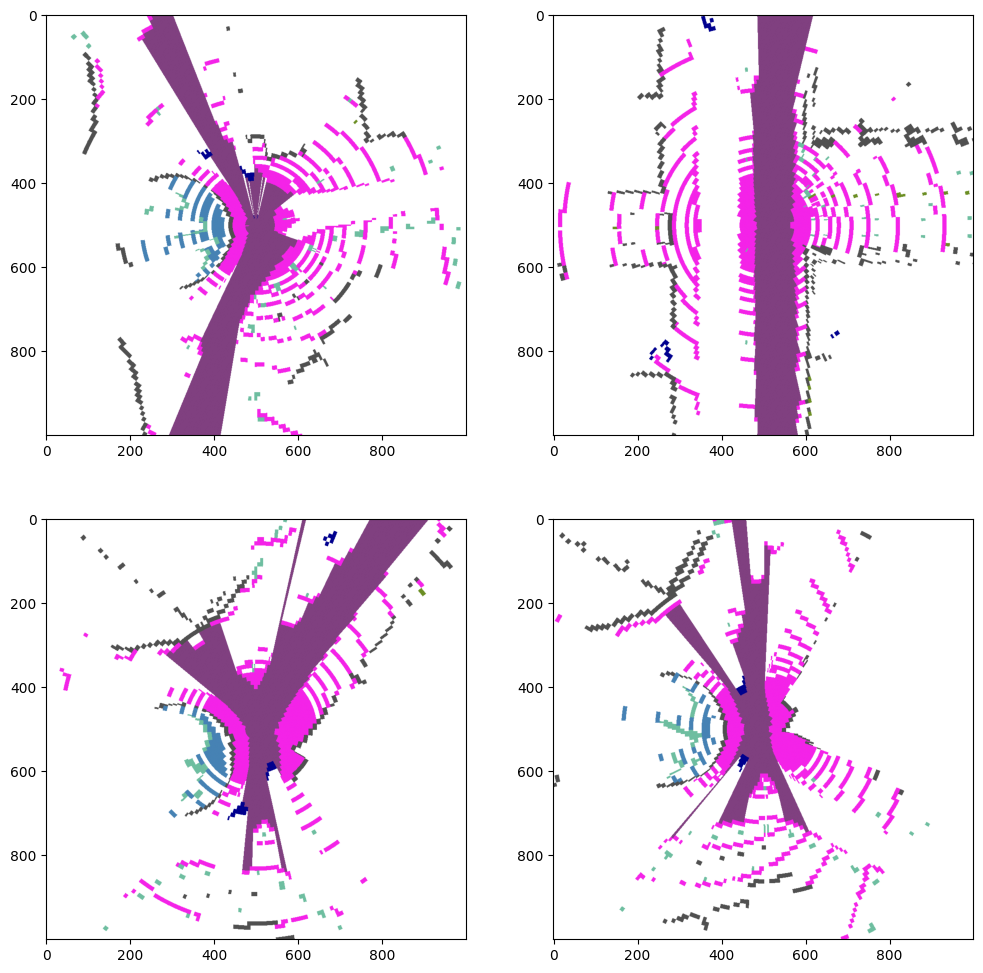

In [81]:
if 'pose4' in globals():
  fig,axs = plt.subplots(2,2,figsize=(12,12))
  axs[0,0].imshow(sgm_pred_1)
  axs[0,1].imshow(sgm_pred_2)
  axs[1,0].imshow(sgm_pred_3)
  axs[1,1].imshow(sgm_pred_4)

  plt.show()

## Shift the SGM

Shift the OGM with the same way as with OGM

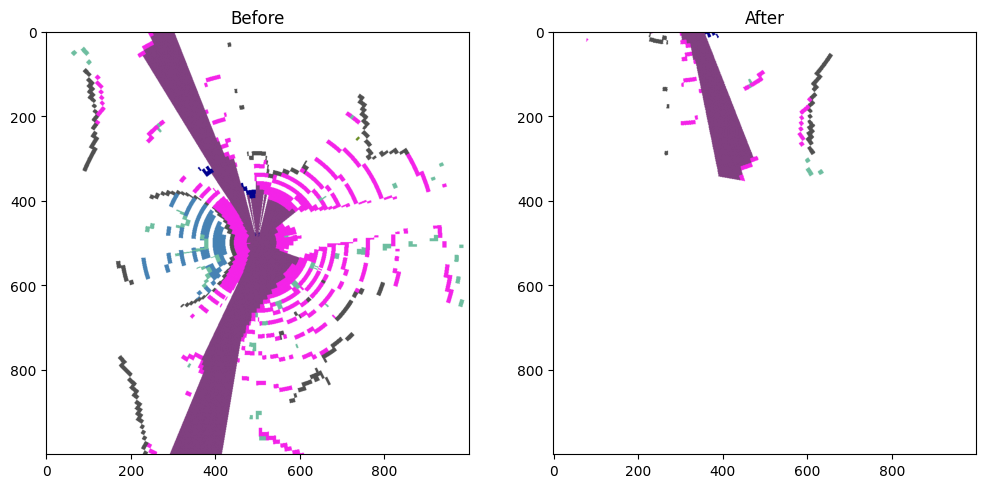

In [82]:
#RESOLUTION=RESOLUTION -25
# Shift the map according the vehicle's poses
def shift_pose_sgm(dgm, init, fin):
  dgm_o = dgm.copy()
  #theta = init[2] /180 * np.pi
  theta = -init[2]
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  point_2 = np.dot(rot_m,-point_1)
  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])



  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(dgm_o,M,(dgm_o.shape[1],dgm_o.shape[0]))
  M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),-delta_theta* 180 / np.pi,1)
  #M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(dgm_o.shape[1],dgm_o.shape[0]))

  search_value = (0, 0, 0, 0, 0, 0, 0, 0, 0)
  border_value = (1, 0, 0, 0, 0, 0, 0, 0, 0)

  # Create a mask for pixels with the search value
  mask = np.all(dst == search_value, axis=-1)

  # Replace the pixels with the replace value
  dst[mask] = border_value

  return dst

shift_sgm_time_1 = shift_pose_sgm(sgm_time_1,pose1,pose2)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((REDUCED_LABEL_COLORS[np.argmax(sgm_time_1,axis=2).astype(int)])))
axs[0].set_title('Before')
axs[1].imshow(((REDUCED_LABEL_COLORS[np.argmax(shift_sgm_time_1,axis=2).astype(int)])))
axs[1].set_title('After')
plt.show()

In [83]:
print(shift_dgm_time_1[400,200])

[0.5 0.  0. ]


## The Second Update

Let's update the map again!

The dynamic cells are colored blue.

[0 1 2 4 5 6 7]


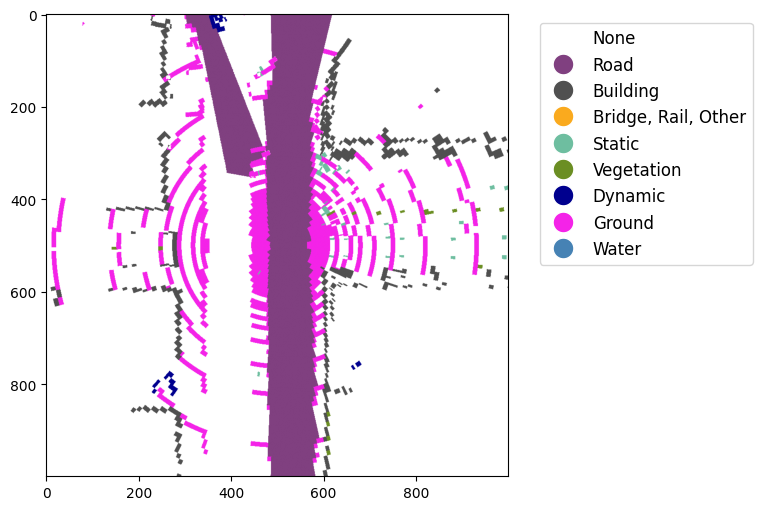

In [84]:
sgm_fuse,dynamic_mass_fuse = update_sgm(shift_sgm_time_1,sgm_time_2)
sgm_pred_fuse = predict_sgm(sgm_fuse,dynamic_mass_fuse,100.5)

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(sgm_pred_fuse)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=reduced_label_names[i], markerfacecolor=REDUCED_LABEL_COLORS[i], markersize=15) for i in range(len(reduced_label_names))]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')

plt.show()

In [85]:
print(np.unique(sgm_pred_fuse.reshape(-1, 3), axis=0))

[[0.         0.         0.55686275]
 [0.31372549 0.31372549 0.31372549]
 [0.41960784 0.55686275 0.1372549 ]
 [0.43137255 0.74509804 0.62745098]
 [0.50196078 0.25098039 0.50196078]
 [0.95686275 0.1372549  0.90980392]
 [1.         1.         1.        ]]


In [86]:
if 'pose3' in globals():
  shift_sgm_time_3 = shift_pose_sgm(sgm_time_3,pose3,pose2)


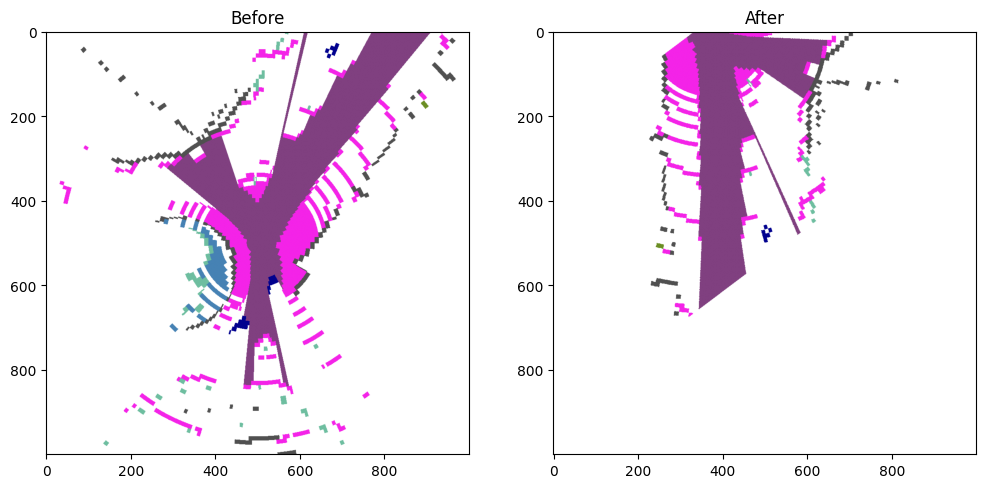

In [87]:
if 'pose3' in globals():
  ### Visualize
  fig,axs = plt.subplots(1,2,figsize=(12,6))
  axs[0].imshow(((REDUCED_LABEL_COLORS[np.argmax(sgm_time_3,axis=2).astype(int)])))
  axs[0].set_title('Before')
  axs[1].imshow(((REDUCED_LABEL_COLORS[np.argmax(shift_sgm_time_3,axis=2).astype(int)])))
  axs[1].set_title('After')
  plt.show()

[0 1 2 4 5 6 7]


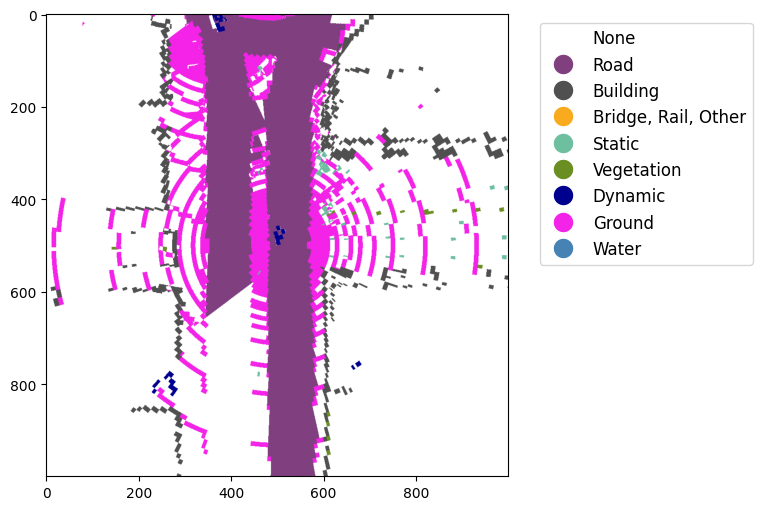

In [88]:
if 'pose3' in globals():
  sgm_fuse,dynamic_mass_fuse = update_sgm(shift_sgm_time_3,sgm_fuse)
  sgm_pred_fuse = predict_sgm(sgm_fuse,dynamic_mass_fuse,100.5)

  fig,axs = plt.subplots(1,1,figsize=(6,6))
  axs.imshow(sgm_pred_fuse)
  legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=reduced_label_names[i], markerfacecolor=REDUCED_LABEL_COLORS[i], markersize=15) for i in range(len(reduced_label_names))]
  plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')

  plt.show()

In [89]:
if 'pose4' in globals():
  shift_sgm_time_4 = shift_pose_sgm(sgm_time_4,pose4,pose2)


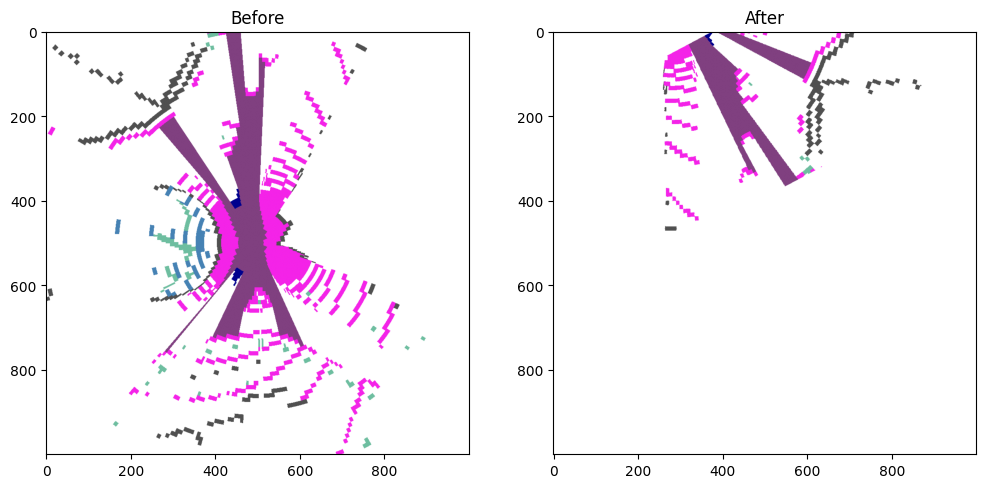

In [90]:
if 'pose4' in globals():
  ### Visualize
  fig,axs = plt.subplots(1,2,figsize=(12,6))
  axs[0].imshow(((REDUCED_LABEL_COLORS[np.argmax(sgm_time_4,axis=2).astype(int)])))
  axs[0].set_title('Before')
  axs[1].imshow(((REDUCED_LABEL_COLORS[np.argmax(shift_sgm_time_4,axis=2).astype(int)])))
  axs[1].set_title('After')
  plt.show()

maybe do dempster on the first 2 and dm by yager for the final fusion

[0 1 2 4 5 6 7]


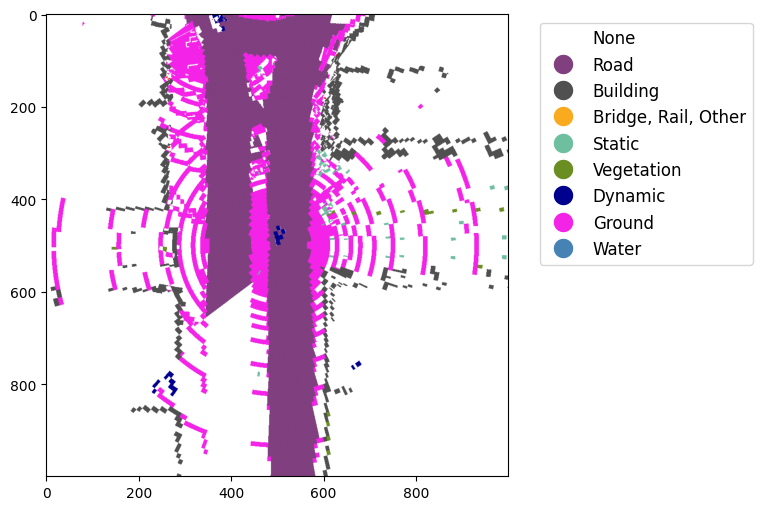

In [91]:
if 'pose4' in globals():
  sgm_fuse,dynamic_mass_fuse = update_sgm(shift_sgm_time_4,sgm_fuse)
  sgm_pred_fuse = predict_sgm(sgm_fuse,dynamic_mass_fuse,100)

  fig,axs = plt.subplots(1,1,figsize=(6,6))
  axs.imshow(sgm_pred_fuse)
  legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=reduced_label_names[i], markerfacecolor=REDUCED_LABEL_COLORS[i], markersize=15) for i in range(len(reduced_label_names))]
  plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')

  plt.show()

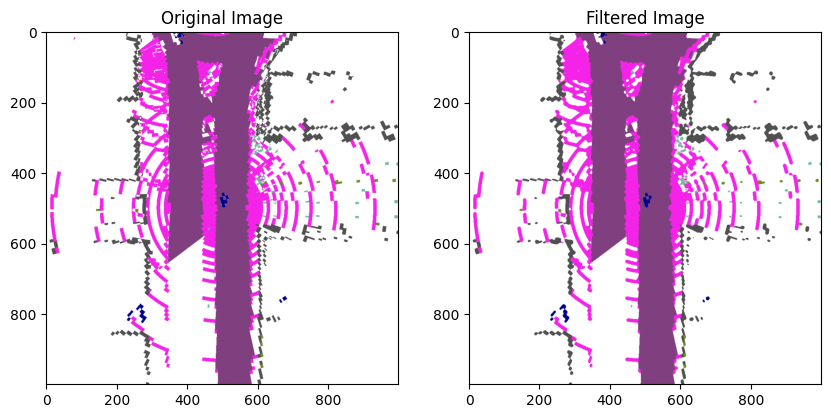

In [92]:
import numpy as np
from scipy.ndimage import median_filter

window_size =7
filtered_image = np.zeros_like(sgm_pred_fuse)
for channel in range(3):
    filtered_image[:, :, channel] = median_filter(sgm_pred_fuse[:, :, channel], size=window_size)

# Display the original and filtered images (optional)

plt.figure(figsize=(10, 12))
plt.subplot(121)
plt.imshow(sgm_pred_fuse)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(filtered_image)
plt.title('Filtered Image')
plt.show()

## test new idea

In [93]:
def update_sgm_test(*new_dgms):
    num_classes = new_dgms[0].shape[2]
    num_inputs = len(new_dgms)

    conflict_mass = np.zeros_like(new_dgms[0][:, :, 0])
    class_mass = np.zeros_like(new_dgms[0][:, :, 1:])
    unknown_mass = np.zeros_like(new_dgms[0][:, :, 0])

    for i in range(num_inputs - 1):
        for j in range(i + 1, num_inputs):
            for k in range(1, num_classes):
                conflict_mass += np.multiply(new_dgms[i][:, :, k], new_dgms[j][:, :, k])
                conflict_mass += np.multiply(new_dgms[j][:, :, k], new_dgms[i][:, :, k])

            for k in range(1, num_classes):
                class_mass[:, :, k-1] += np.multiply(new_dgms[i][:, :, 0], new_dgms[j][:, :, k])
                class_mass[:, :, k-1] += np.multiply(new_dgms[i][:, :, k], new_dgms[j][:, :, 0])
                #class_mass[:, :, k-1] = np.divide(class_mass[:, :, k-1], np.ones_like(conflict_mass) - conflict_mass + 1e-10)#DS
                #class_mass[:, :, k-1] += conflict_mass #yager
            unknown_mass *= np.multiply(unknown_mass, new_dgms[j][:, :, 0])
            #unknown_mass = np.divide(unknown_mass,np.ones_like(conflict_mass) - conflict_mass+1e-10) #DS
            #unknown_mass += conflict_mass #yager
    updated_dgm = np.dstack((unknown_mass, class_mass))

    for i in range(new_dgms[-1].shape[0]):
        for j in range(new_dgms[-1].shape[1]):
            if np.array_equal(new_dgms[-1][i, j], updated_dgm[i, j]):
                updated_dgm[i, j] = new_dgms[-1][i, j]

    return updated_dgm, conflict_mass




[0 1 2 4 5 6 7]


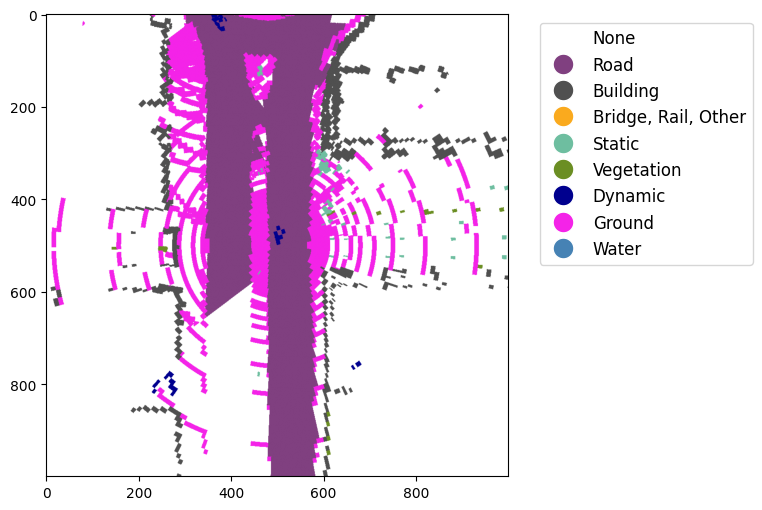

In [94]:
sgm_fuse,dynamic_mass_fuse = update_sgm_test(sgm_time_2,shift_sgm_time_1,shift_sgm_time_3,shift_sgm_time_4)
sgm_pred_fuse = predict_sgm(sgm_fuse,dynamic_mass_fuse,100)

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(sgm_pred_fuse)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=reduced_label_names[i], markerfacecolor=REDUCED_LABEL_COLORS[i], markersize=15) for i in range(len(reduced_label_names))]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')

plt.show()